__Summary__
 - загружаем данные из yfinance (пока по одной компании, потом надо будет выбрать несколько) и считаем темп прироста - это 1ая группа фичей
 - загружаем данные из GDELT и вытаскиваем тональность новостей ( потом надо подумать, сколько новостей за день брать (сейчас по умолчанию 250 и как их агрегировать в одно значение - сейчас по среднему и это имхо не очень) - это 2ая группа фичей
 <span class="burk">- таргет - с этим сложности, пока придумала сделать так - цена закрытия-цена открытия и сделать бинарным значени: 0 - падение, 1 - рост, но у нас фича growth повторяет таргет</span>
 - пробуем gatboost/gxboost/lightgbm/нейронки (LSTM?) 
 - смотрим на интрепретируемость модели (shap)


__что еще не сделала__
- поперебирать гиперпараметры с помощью optuna/hyperopt, сменить подход под grisearch
- добавить вариант с нейронками
- интрепретируемость модели (shap)
- САМОЕ ГЛАВНОЕ - данные порисечить, может что-то лучше найду и решить вопрос с таргетом, сейчас КРИВО

## данные по NVIDIA из yfinance

In [1]:
import yfinance as yf

In [5]:
#tickers = yf.download('msft aapl goog', start="2020-01-01", end="2020-12-30")
tickers = yf.Tickers('nvda')

In [6]:
tickers.tickers.NVDA.history(period="1mo")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-12-30,519.609985,528.549988,515.869995,525.830017,5634900,0,0
2020-12-31,525.460022,526.039978,516.599976,522.200012,4806500,0,0
2021-01-04,524.169983,546.099976,518.500000,524.539978,14016000,0,0
2021-01-05,523.989990,537.739990,523.479980,536.190002,8069000,0,0
2021-01-06,528.900024,529.799988,503.440002,504.579987,14510600,0,0
2021-01-07,518.700012,535.109985,515.460022,533.760010,11537000,0,0
2021-01-08,534.500000,536.840027,521.679993,531.070007,7302500,0,0
2021-01-11,536.750000,558.440002,534.500000,544.859985,12975700,0,0
2021-01-12,550.099976,550.179993,533.799988,539.390015,7286900,0,0


In [8]:
type(tickers.tickers.NVDA.history(period="1mo"))

pandas.core.frame.DataFrame

In [40]:
df_stock = tickers.tickers.NVDA.history(period="1mo")

In [41]:
len(df_stock)

21

### Считаем таргет (оч сомнительный вариант, но другого не придумала)

In [43]:
df_stock['target'] = (df_stock['Close'] - df_stock['Open'])

In [44]:
df_stock['target'] = df_stock['target'].apply(lambda x: 1 if x > 0 else 0)

### вытаскиваем новую фичу - темп прироста

In [46]:
df_stock.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'target'],
      dtype='object')

In [47]:
df_stock['growth'] = ((df_stock['Close'] - df_stock['Open'])/df_stock['Open'])*100

In [48]:
df_stock.head(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,target,growth
Date,,,,,,,,,
2020-12-30,519.609985,528.549988,515.869995,525.830017,5634900,0,0,1,1.197058
2020-12-31,525.460022,526.039978,516.599976,522.200012,4806500,0,0,0,-0.620411


In [49]:
df_stock = df_stock.groupby(pd.Grouper(level="Date", freq="1D")).mean(); 
df_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,target,growth
Date,,,,,,,,,
2020-12-30,519.609985,528.549988,515.869995,525.830017,5634900.0,0.0,0.0,1.0,1.197058
2020-12-31,525.460022,526.039978,516.599976,522.200012,4806500.0,0.0,0.0,0.0,-0.620411
2021-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
len(df_stock)

31

## данные по NVIDIA из GDELT

In [21]:
from gdeltdoc import GdeltDoc, Filters, near, repeat
import pandas as pd

In [51]:
features = [
    'nvidia', 'geforce', 'geforce rtx', 'geForce now', 'nvidia rtx', 'nvidia shield', 'nvidia dgx'
]

In [52]:
for ft in features:
    f = Filters(
        start_date = "2020-12-30",
        end_date = "2021-01-29",
        num_records = 250,
        keyword = ft,
    #     domain = ["bbc.co.uk", "nytimes.com", "cnn.com"],
    #     country = ["UK", "US"],
    #     theme = "ECON_STOCKMARKET",

    #     near = near(3, "amazon", "stock"),
    #     repeat = repeat(3, "stock")
    )
    gd = GdeltDoc()
    # Get a timeline of the number of articles matching the filters
    timelinetone = gd.timeline_search("timelinetone", f)
    timelinetone = timelinetone.groupby(pd.Grouper(key="datetime", freq="1D")).mean()
    
    timelinevolraw = gd.timeline_search("timelinevolraw", f)
    timelinevolraw = timelinevolraw.groupby(pd.Grouper(key="datetime", freq="1D")).sum()

    
    df_stock[f'{ft}_av_tone'] = timelinetone['Average Tone'].values
    df_stock[f'{ft}_art_count'] = timelinevolraw['Article Count'].values

In [53]:
df_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,target,growth,nvidia_av_tone,...,geforce rtx_av_tone,geforce rtx_art_count,geForce now_av_tone,geForce now_art_count,nvidia rtx_av_tone,nvidia rtx_art_count,nvidia shield_av_tone,nvidia shield_art_count,nvidia dgx_av_tone,nvidia dgx_art_count
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-30,519.609985,528.549988,515.869995,525.830017,5634900.0,0.0,0.0,1.0,1.197058,0.4726,...,0.4256,26,-1.0357,4,0.4205,12,0.0000,0,0.0,0
2020-12-31,525.460022,526.039978,516.599976,522.200012,4806500.0,0.0,0.0,0.0,-0.620411,0.2793,...,0.0562,37,0.8861,1,0.0350,17,1.1273,2,0.0,0
2021-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.4436,...,1.3784,19,0.0000,0,1.0517,10,0.6637,3,0.0,0
2021-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0331,...,0.4649,10,0.0000,0,0.8928,5,0.0000,0,0.0,0
2021-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0292,...,1.3739,6,-2.1891,1,1.4328,10,0.0000,0,0.0,0


In [61]:
len(df_stock)

31

вот тут надо подумать - просто грохнула Nan, а можно было заменить на значения предыдущего дня/нули

In [62]:
df_stock.dropna(inplace=True)

In [63]:
len(df_stock)

21

## Модели

In [33]:
# import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# set the aesthetic style of the plots
sns.set_style()

# filter warning messages
import warnings
warnings.filterwarnings('ignore')

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [64]:
# feature matrix
X = df_stock.drop('target', axis=1)

# target vector
y = df_stock['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)


In [65]:
# standardize numerical variables
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# resample
#rus = RandomUnderSampler()
#X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

In [59]:
# define the function val_model
def val_model(X, y, clf, show=True):
    """
    Apply cross-validation on the training set.

    # Arguments
        X: DataFrame containing the independent variables.
        y: Series containing the target vector.
        clf: Scikit-learn estimator instance.
        
    # Returns
        float, mean value of the cross-validation scores.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if show == True:
        print(f'Recall: {scores.mean()}, {scores.std()}')
    
    return scores.mean()

In [66]:
#evaluate the models
xgb = XGBClassifier()
lgb = LGBMClassifier()
cb = CatBoostClassifier()

model = []
recall = []

for clf in (xgb, lgb, cb):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train, y_train, clf, show=False))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

Learning rate set to 0.001559
0:	learn: 0.6919289	total: 54.7ms	remaining: 54.6s
1:	learn: 0.6909011	total: 56.2ms	remaining: 28s
2:	learn: 0.6895003	total: 57.4ms	remaining: 19.1s
3:	learn: 0.6881786	total: 58.8ms	remaining: 14.6s
4:	learn: 0.6873027	total: 59.6ms	remaining: 11.9s
5:	learn: 0.6862838	total: 60.4ms	remaining: 10s
6:	learn: 0.6852313	total: 61.3ms	remaining: 8.69s
7:	learn: 0.6842165	total: 62.1ms	remaining: 7.7s
8:	learn: 0.6832035	total: 62.9ms	remaining: 6.92s
9:	learn: 0.6822672	total: 63.5ms	remaining: 6.29s
10:	learn: 0.6814074	total: 64.4ms	remaining: 5.79s
11:	learn: 0.6802152	total: 65ms	remaining: 5.36s
12:	learn: 0.6792099	total: 65.8ms	remaining: 5s
13:	learn: 0.6781320	total: 66.5ms	remaining: 4.68s
14:	learn: 0.6772734	total: 67.4ms	remaining: 4.42s
15:	learn: 0.6760908	total: 68.2ms	remaining: 4.19s
16:	learn: 0.6750854	total: 68.9ms	remaining: 3.98s
17:	learn: 0.6742319	total: 69.7ms	remaining: 3.8s
18:	learn: 0.6732375	total: 70.5ms	remaining: 3.64s
19:

162:	learn: 0.5363754	total: 176ms	remaining: 903ms
163:	learn: 0.5350290	total: 177ms	remaining: 902ms
164:	learn: 0.5343556	total: 178ms	remaining: 902ms
165:	learn: 0.5336286	total: 179ms	remaining: 900ms
166:	learn: 0.5329554	total: 180ms	remaining: 898ms
167:	learn: 0.5317823	total: 181ms	remaining: 895ms
168:	learn: 0.5309728	total: 182ms	remaining: 893ms
169:	learn: 0.5300233	total: 182ms	remaining: 890ms
170:	learn: 0.5293590	total: 183ms	remaining: 888ms
171:	learn: 0.5286962	total: 184ms	remaining: 887ms
172:	learn: 0.5276997	total: 185ms	remaining: 885ms
173:	learn: 0.5268543	total: 186ms	remaining: 883ms
174:	learn: 0.5258054	total: 187ms	remaining: 880ms
175:	learn: 0.5250918	total: 188ms	remaining: 880ms
176:	learn: 0.5243795	total: 189ms	remaining: 880ms
177:	learn: 0.5237791	total: 190ms	remaining: 878ms
178:	learn: 0.5229854	total: 191ms	remaining: 875ms
179:	learn: 0.5221427	total: 192ms	remaining: 874ms
180:	learn: 0.5214925	total: 193ms	remaining: 871ms
181:	learn: 

372:	learn: 0.3996573	total: 348ms	remaining: 584ms
373:	learn: 0.3991351	total: 349ms	remaining: 584ms
374:	learn: 0.3986524	total: 350ms	remaining: 584ms
375:	learn: 0.3981085	total: 351ms	remaining: 583ms
376:	learn: 0.3975276	total: 352ms	remaining: 582ms
377:	learn: 0.3970507	total: 353ms	remaining: 581ms
378:	learn: 0.3963578	total: 354ms	remaining: 580ms
379:	learn: 0.3958427	total: 356ms	remaining: 580ms
380:	learn: 0.3952670	total: 356ms	remaining: 579ms
381:	learn: 0.3947363	total: 357ms	remaining: 578ms
382:	learn: 0.3941229	total: 358ms	remaining: 577ms
383:	learn: 0.3936448	total: 360ms	remaining: 577ms
384:	learn: 0.3931708	total: 361ms	remaining: 576ms
385:	learn: 0.3926012	total: 362ms	remaining: 575ms
386:	learn: 0.3919811	total: 362ms	remaining: 574ms
387:	learn: 0.3914568	total: 363ms	remaining: 573ms
388:	learn: 0.3910251	total: 365ms	remaining: 573ms
389:	learn: 0.3903490	total: 366ms	remaining: 572ms
390:	learn: 0.3898809	total: 367ms	remaining: 572ms
391:	learn: 

577:	learn: 0.3082271	total: 523ms	remaining: 382ms
578:	learn: 0.3078261	total: 524ms	remaining: 381ms
579:	learn: 0.3074969	total: 525ms	remaining: 380ms
580:	learn: 0.3070421	total: 526ms	remaining: 379ms
581:	learn: 0.3067426	total: 527ms	remaining: 378ms
582:	learn: 0.3064453	total: 528ms	remaining: 378ms
583:	learn: 0.3059795	total: 529ms	remaining: 376ms
584:	learn: 0.3054525	total: 529ms	remaining: 376ms
585:	learn: 0.3050536	total: 530ms	remaining: 375ms
586:	learn: 0.3047589	total: 531ms	remaining: 374ms
587:	learn: 0.3044651	total: 532ms	remaining: 373ms
588:	learn: 0.3041454	total: 533ms	remaining: 372ms
589:	learn: 0.3037815	total: 534ms	remaining: 371ms
590:	learn: 0.3034887	total: 535ms	remaining: 370ms
591:	learn: 0.3032225	total: 536ms	remaining: 369ms
592:	learn: 0.3028029	total: 537ms	remaining: 368ms
593:	learn: 0.3024819	total: 538ms	remaining: 368ms
594:	learn: 0.3021909	total: 540ms	remaining: 368ms
595:	learn: 0.3018991	total: 542ms	remaining: 367ms
596:	learn: 

811:	learn: 0.2365703	total: 694ms	remaining: 161ms
812:	learn: 0.2362279	total: 695ms	remaining: 160ms
813:	learn: 0.2359915	total: 696ms	remaining: 159ms
814:	learn: 0.2357546	total: 697ms	remaining: 158ms
815:	learn: 0.2355412	total: 698ms	remaining: 157ms
816:	learn: 0.2352847	total: 699ms	remaining: 157ms
817:	learn: 0.2350376	total: 700ms	remaining: 156ms
818:	learn: 0.2348017	total: 701ms	remaining: 155ms
819:	learn: 0.2345585	total: 702ms	remaining: 154ms
820:	learn: 0.2343644	total: 703ms	remaining: 153ms
821:	learn: 0.2341026	total: 704ms	remaining: 152ms
822:	learn: 0.2338342	total: 705ms	remaining: 152ms
823:	learn: 0.2335464	total: 706ms	remaining: 151ms
824:	learn: 0.2332535	total: 706ms	remaining: 150ms
825:	learn: 0.2330417	total: 707ms	remaining: 149ms
826:	learn: 0.2327903	total: 708ms	remaining: 148ms
827:	learn: 0.2325576	total: 709ms	remaining: 147ms
828:	learn: 0.2323463	total: 710ms	remaining: 146ms
829:	learn: 0.2321551	total: 711ms	remaining: 146ms
830:	learn: 

9:	learn: 0.6813425	total: 11.8ms	remaining: 1.17s
10:	learn: 0.6801695	total: 12.5ms	remaining: 1.12s
11:	learn: 0.6793404	total: 13.4ms	remaining: 1.1s
12:	learn: 0.6782271	total: 14.2ms	remaining: 1.08s
13:	learn: 0.6774418	total: 15ms	remaining: 1.05s
14:	learn: 0.6765846	total: 16.3ms	remaining: 1.07s
15:	learn: 0.6751617	total: 17.7ms	remaining: 1.09s
16:	learn: 0.6743821	total: 18.6ms	remaining: 1.08s
17:	learn: 0.6734206	total: 19.5ms	remaining: 1.06s
18:	learn: 0.6725019	total: 20.5ms	remaining: 1.06s
19:	learn: 0.6714018	total: 21.4ms	remaining: 1.05s
20:	learn: 0.6705600	total: 22.3ms	remaining: 1.04s
21:	learn: 0.6696460	total: 23.7ms	remaining: 1.05s
22:	learn: 0.6685873	total: 24.9ms	remaining: 1.06s
23:	learn: 0.6673507	total: 25.9ms	remaining: 1.05s
24:	learn: 0.6661896	total: 26.7ms	remaining: 1.04s
25:	learn: 0.6651379	total: 27.7ms	remaining: 1.04s
26:	learn: 0.6643008	total: 28.8ms	remaining: 1.04s
27:	learn: 0.6633983	total: 30.5ms	remaining: 1.06s
28:	learn: 0.662

211:	learn: 0.5033165	total: 182ms	remaining: 678ms
212:	learn: 0.5027358	total: 183ms	remaining: 676ms
213:	learn: 0.5020634	total: 184ms	remaining: 677ms
214:	learn: 0.5013935	total: 186ms	remaining: 678ms
215:	learn: 0.5008991	total: 187ms	remaining: 679ms
216:	learn: 0.5002859	total: 189ms	remaining: 680ms
217:	learn: 0.4998339	total: 190ms	remaining: 681ms
218:	learn: 0.4990413	total: 191ms	remaining: 680ms
219:	learn: 0.4983794	total: 192ms	remaining: 680ms
220:	learn: 0.4972552	total: 192ms	remaining: 678ms
221:	learn: 0.4969309	total: 193ms	remaining: 678ms
222:	learn: 0.4963338	total: 195ms	remaining: 678ms
223:	learn: 0.4956763	total: 196ms	remaining: 678ms
224:	learn: 0.4951803	total: 197ms	remaining: 677ms
225:	learn: 0.4944491	total: 198ms	remaining: 677ms
226:	learn: 0.4940008	total: 198ms	remaining: 676ms
227:	learn: 0.4935861	total: 200ms	remaining: 676ms
228:	learn: 0.4928057	total: 201ms	remaining: 677ms
229:	learn: 0.4922724	total: 202ms	remaining: 678ms
230:	learn: 

436:	learn: 0.3706924	total: 353ms	remaining: 455ms
437:	learn: 0.3702961	total: 355ms	remaining: 455ms
438:	learn: 0.3699000	total: 356ms	remaining: 454ms
439:	learn: 0.3694285	total: 356ms	remaining: 454ms
440:	learn: 0.3690361	total: 357ms	remaining: 453ms
441:	learn: 0.3687037	total: 358ms	remaining: 452ms
442:	learn: 0.3683062	total: 359ms	remaining: 451ms
443:	learn: 0.3677877	total: 360ms	remaining: 451ms
444:	learn: 0.3674301	total: 361ms	remaining: 450ms
445:	learn: 0.3671223	total: 362ms	remaining: 449ms
446:	learn: 0.3666936	total: 363ms	remaining: 449ms
447:	learn: 0.3662320	total: 364ms	remaining: 448ms
448:	learn: 0.3655370	total: 365ms	remaining: 447ms
449:	learn: 0.3651496	total: 365ms	remaining: 447ms
450:	learn: 0.3646744	total: 366ms	remaining: 446ms
451:	learn: 0.3642493	total: 368ms	remaining: 446ms
452:	learn: 0.3637549	total: 368ms	remaining: 445ms
453:	learn: 0.3632513	total: 370ms	remaining: 445ms
454:	learn: 0.3629254	total: 371ms	remaining: 444ms
455:	learn: 

637:	learn: 0.2887582	total: 528ms	remaining: 299ms
638:	learn: 0.2885119	total: 529ms	remaining: 299ms
639:	learn: 0.2881341	total: 531ms	remaining: 299ms
640:	learn: 0.2879182	total: 532ms	remaining: 298ms
641:	learn: 0.2874628	total: 533ms	remaining: 297ms
642:	learn: 0.2871411	total: 534ms	remaining: 297ms
643:	learn: 0.2868476	total: 536ms	remaining: 296ms
644:	learn: 0.2865298	total: 537ms	remaining: 296ms
645:	learn: 0.2862560	total: 539ms	remaining: 295ms
646:	learn: 0.2858997	total: 540ms	remaining: 295ms
647:	learn: 0.2855948	total: 541ms	remaining: 294ms
648:	learn: 0.2853043	total: 542ms	remaining: 293ms
649:	learn: 0.2849057	total: 543ms	remaining: 293ms
650:	learn: 0.2845232	total: 544ms	remaining: 292ms
651:	learn: 0.2841797	total: 546ms	remaining: 291ms
652:	learn: 0.2837581	total: 547ms	remaining: 291ms
653:	learn: 0.2833922	total: 549ms	remaining: 290ms
654:	learn: 0.2831340	total: 550ms	remaining: 290ms
655:	learn: 0.2828716	total: 551ms	remaining: 289ms
656:	learn: 

857:	learn: 0.2272014	total: 699ms	remaining: 116ms
858:	learn: 0.2269418	total: 700ms	remaining: 115ms
859:	learn: 0.2267353	total: 701ms	remaining: 114ms
860:	learn: 0.2265118	total: 702ms	remaining: 113ms
861:	learn: 0.2262889	total: 703ms	remaining: 113ms
862:	learn: 0.2260200	total: 704ms	remaining: 112ms
863:	learn: 0.2258371	total: 705ms	remaining: 111ms
864:	learn: 0.2254396	total: 706ms	remaining: 110ms
865:	learn: 0.2252175	total: 707ms	remaining: 109ms
866:	learn: 0.2250357	total: 708ms	remaining: 109ms
867:	learn: 0.2247911	total: 709ms	remaining: 108ms
868:	learn: 0.2244533	total: 710ms	remaining: 107ms
869:	learn: 0.2241702	total: 711ms	remaining: 106ms
870:	learn: 0.2239216	total: 712ms	remaining: 105ms
871:	learn: 0.2236668	total: 713ms	remaining: 105ms
872:	learn: 0.2234651	total: 713ms	remaining: 104ms
873:	learn: 0.2230864	total: 714ms	remaining: 103ms
874:	learn: 0.2228392	total: 715ms	remaining: 102ms
875:	learn: 0.2225810	total: 716ms	remaining: 101ms
876:	learn: 

68:	learn: 0.6206747	total: 55.1ms	remaining: 744ms
69:	learn: 0.6196484	total: 56.8ms	remaining: 755ms
70:	learn: 0.6184054	total: 57.5ms	remaining: 753ms
71:	learn: 0.6169493	total: 58.1ms	remaining: 749ms
72:	learn: 0.6162563	total: 58.8ms	remaining: 747ms
73:	learn: 0.6154400	total: 59.5ms	remaining: 745ms
74:	learn: 0.6143924	total: 60.1ms	remaining: 742ms
75:	learn: 0.6134153	total: 60.8ms	remaining: 739ms
76:	learn: 0.6126696	total: 61.5ms	remaining: 737ms
77:	learn: 0.6115626	total: 62.1ms	remaining: 734ms
78:	learn: 0.6105560	total: 62.6ms	remaining: 730ms
79:	learn: 0.6097498	total: 63.3ms	remaining: 728ms
80:	learn: 0.6089446	total: 63.9ms	remaining: 725ms
81:	learn: 0.6080099	total: 64.5ms	remaining: 722ms
82:	learn: 0.6068809	total: 65.2ms	remaining: 720ms
83:	learn: 0.6056378	total: 66.4ms	remaining: 724ms
84:	learn: 0.6050871	total: 67.2ms	remaining: 723ms
85:	learn: 0.6043102	total: 68.2ms	remaining: 725ms
86:	learn: 0.6034493	total: 69.1ms	remaining: 725ms
87:	learn: 0

301:	learn: 0.4371351	total: 226ms	remaining: 522ms
302:	learn: 0.4363272	total: 227ms	remaining: 522ms
303:	learn: 0.4357778	total: 228ms	remaining: 521ms
304:	learn: 0.4351164	total: 229ms	remaining: 522ms
305:	learn: 0.4345666	total: 230ms	remaining: 522ms
306:	learn: 0.4339216	total: 231ms	remaining: 522ms
307:	learn: 0.4333777	total: 232ms	remaining: 521ms
308:	learn: 0.4330015	total: 233ms	remaining: 521ms
309:	learn: 0.4324556	total: 234ms	remaining: 521ms
310:	learn: 0.4318063	total: 235ms	remaining: 521ms
311:	learn: 0.4313079	total: 236ms	remaining: 520ms
312:	learn: 0.4306563	total: 237ms	remaining: 520ms
313:	learn: 0.4301194	total: 238ms	remaining: 520ms
314:	learn: 0.4295825	total: 239ms	remaining: 521ms
315:	learn: 0.4290027	total: 240ms	remaining: 520ms
316:	learn: 0.4284659	total: 241ms	remaining: 520ms
317:	learn: 0.4280112	total: 243ms	remaining: 521ms
318:	learn: 0.4275187	total: 244ms	remaining: 521ms
319:	learn: 0.4269445	total: 245ms	remaining: 522ms
320:	learn: 

524:	learn: 0.3245498	total: 396ms	remaining: 359ms
525:	learn: 0.3240879	total: 397ms	remaining: 358ms
526:	learn: 0.3237000	total: 398ms	remaining: 358ms
527:	learn: 0.3231096	total: 399ms	remaining: 357ms
528:	learn: 0.3227593	total: 400ms	remaining: 356ms
529:	learn: 0.3224665	total: 401ms	remaining: 355ms
530:	learn: 0.3221148	total: 402ms	remaining: 355ms
531:	learn: 0.3217338	total: 403ms	remaining: 354ms
532:	learn: 0.3213378	total: 403ms	remaining: 353ms
533:	learn: 0.3210964	total: 404ms	remaining: 352ms
534:	learn: 0.3207176	total: 405ms	remaining: 352ms
535:	learn: 0.3203399	total: 405ms	remaining: 351ms
536:	learn: 0.3199931	total: 407ms	remaining: 351ms
537:	learn: 0.3196733	total: 408ms	remaining: 350ms
538:	learn: 0.3192989	total: 409ms	remaining: 350ms
539:	learn: 0.3190109	total: 410ms	remaining: 349ms
540:	learn: 0.3186041	total: 411ms	remaining: 348ms
541:	learn: 0.3182295	total: 412ms	remaining: 348ms
542:	learn: 0.3179879	total: 413ms	remaining: 348ms
543:	learn: 

759:	learn: 0.2474543	total: 566ms	remaining: 179ms
760:	learn: 0.2471698	total: 567ms	remaining: 178ms
761:	learn: 0.2468287	total: 568ms	remaining: 177ms
762:	learn: 0.2465092	total: 569ms	remaining: 177ms
763:	learn: 0.2462467	total: 570ms	remaining: 176ms
764:	learn: 0.2460042	total: 571ms	remaining: 175ms
765:	learn: 0.2457198	total: 572ms	remaining: 175ms
766:	learn: 0.2454464	total: 573ms	remaining: 174ms
767:	learn: 0.2452881	total: 574ms	remaining: 173ms
768:	learn: 0.2450151	total: 575ms	remaining: 173ms
769:	learn: 0.2447449	total: 576ms	remaining: 172ms
770:	learn: 0.2445151	total: 577ms	remaining: 171ms
771:	learn: 0.2442833	total: 578ms	remaining: 171ms
772:	learn: 0.2440350	total: 579ms	remaining: 170ms
773:	learn: 0.2437198	total: 580ms	remaining: 169ms
774:	learn: 0.2433718	total: 581ms	remaining: 169ms
775:	learn: 0.2430711	total: 582ms	remaining: 168ms
776:	learn: 0.2428442	total: 582ms	remaining: 167ms
777:	learn: 0.2425972	total: 584ms	remaining: 167ms
778:	learn: 

981:	learn: 0.1978789	total: 738ms	remaining: 13.5ms
982:	learn: 0.1976742	total: 739ms	remaining: 12.8ms
983:	learn: 0.1974697	total: 740ms	remaining: 12ms
984:	learn: 0.1972194	total: 741ms	remaining: 11.3ms
985:	learn: 0.1970732	total: 742ms	remaining: 10.5ms
986:	learn: 0.1968634	total: 743ms	remaining: 9.79ms
987:	learn: 0.1966448	total: 744ms	remaining: 9.03ms
988:	learn: 0.1964217	total: 745ms	remaining: 8.29ms
989:	learn: 0.1962094	total: 746ms	remaining: 7.54ms
990:	learn: 0.1959688	total: 747ms	remaining: 6.79ms
991:	learn: 0.1957412	total: 748ms	remaining: 6.03ms
992:	learn: 0.1955426	total: 749ms	remaining: 5.28ms
993:	learn: 0.1953454	total: 750ms	remaining: 4.53ms
994:	learn: 0.1952015	total: 751ms	remaining: 3.77ms
995:	learn: 0.1950189	total: 752ms	remaining: 3.02ms
996:	learn: 0.1948474	total: 753ms	remaining: 2.27ms
997:	learn: 0.1946369	total: 754ms	remaining: 1.51ms
998:	learn: 0.1945456	total: 755ms	remaining: 756us
999:	learn: 0.1943566	total: 756ms	remaining: 0us

176:	learn: 0.5304193	total: 138ms	remaining: 643ms
177:	learn: 0.5296155	total: 139ms	remaining: 644ms
178:	learn: 0.5288961	total: 141ms	remaining: 645ms
179:	learn: 0.5280383	total: 142ms	remaining: 645ms
180:	learn: 0.5271261	total: 142ms	remaining: 644ms
181:	learn: 0.5264104	total: 143ms	remaining: 645ms
182:	learn: 0.5256901	total: 144ms	remaining: 645ms
183:	learn: 0.5251872	total: 146ms	remaining: 648ms
184:	learn: 0.5239699	total: 147ms	remaining: 648ms
185:	learn: 0.5229081	total: 148ms	remaining: 647ms
186:	learn: 0.5222029	total: 149ms	remaining: 646ms
187:	learn: 0.5214964	total: 150ms	remaining: 646ms
188:	learn: 0.5207339	total: 150ms	remaining: 646ms
189:	learn: 0.5200304	total: 151ms	remaining: 646ms
190:	learn: 0.5194248	total: 152ms	remaining: 645ms
191:	learn: 0.5189350	total: 154ms	remaining: 647ms
192:	learn: 0.5181804	total: 156ms	remaining: 651ms
193:	learn: 0.5173978	total: 157ms	remaining: 652ms
194:	learn: 0.5167541	total: 158ms	remaining: 652ms
195:	learn: 

416:	learn: 0.3816229	total: 310ms	remaining: 433ms
417:	learn: 0.3811707	total: 311ms	remaining: 433ms
418:	learn: 0.3807933	total: 312ms	remaining: 432ms
419:	learn: 0.3805227	total: 313ms	remaining: 432ms
420:	learn: 0.3800221	total: 314ms	remaining: 431ms
421:	learn: 0.3796112	total: 314ms	remaining: 431ms
422:	learn: 0.3791635	total: 315ms	remaining: 430ms
423:	learn: 0.3782932	total: 316ms	remaining: 429ms
424:	learn: 0.3777510	total: 317ms	remaining: 429ms
425:	learn: 0.3773787	total: 318ms	remaining: 428ms
426:	learn: 0.3767476	total: 319ms	remaining: 428ms
427:	learn: 0.3762112	total: 319ms	remaining: 427ms
428:	learn: 0.3756392	total: 320ms	remaining: 426ms
429:	learn: 0.3751640	total: 321ms	remaining: 426ms
430:	learn: 0.3746692	total: 322ms	remaining: 425ms
431:	learn: 0.3743015	total: 323ms	remaining: 425ms
432:	learn: 0.3739246	total: 324ms	remaining: 424ms
433:	learn: 0.3735202	total: 325ms	remaining: 423ms
434:	learn: 0.3729920	total: 325ms	remaining: 423ms
435:	learn: 

603:	learn: 0.3055552	total: 484ms	remaining: 317ms
604:	learn: 0.3051624	total: 485ms	remaining: 316ms
605:	learn: 0.3048657	total: 486ms	remaining: 316ms
606:	learn: 0.3045685	total: 488ms	remaining: 316ms
607:	learn: 0.3041747	total: 488ms	remaining: 315ms
608:	learn: 0.3037386	total: 490ms	remaining: 315ms
609:	learn: 0.3033449	total: 491ms	remaining: 314ms
610:	learn: 0.3029771	total: 494ms	remaining: 314ms
611:	learn: 0.3026855	total: 495ms	remaining: 314ms
612:	learn: 0.3024205	total: 497ms	remaining: 314ms
613:	learn: 0.3018826	total: 498ms	remaining: 313ms
614:	learn: 0.3012415	total: 499ms	remaining: 312ms
615:	learn: 0.3009506	total: 501ms	remaining: 312ms
616:	learn: 0.3007023	total: 502ms	remaining: 312ms
617:	learn: 0.3004139	total: 504ms	remaining: 311ms
618:	learn: 0.3000449	total: 505ms	remaining: 311ms
619:	learn: 0.2997835	total: 507ms	remaining: 311ms
620:	learn: 0.2995647	total: 508ms	remaining: 310ms
621:	learn: 0.2992102	total: 510ms	remaining: 310ms
622:	learn: 

949:	learn: 0.2107194	total: 825ms	remaining: 43.4ms
950:	learn: 0.2105134	total: 826ms	remaining: 42.6ms
951:	learn: 0.2103088	total: 828ms	remaining: 41.7ms
952:	learn: 0.2099842	total: 829ms	remaining: 40.9ms
953:	learn: 0.2098487	total: 830ms	remaining: 40ms
954:	learn: 0.2096691	total: 831ms	remaining: 39.1ms
955:	learn: 0.2094167	total: 831ms	remaining: 38.3ms
956:	learn: 0.2091950	total: 832ms	remaining: 37.4ms
957:	learn: 0.2090002	total: 833ms	remaining: 36.5ms
958:	learn: 0.2088027	total: 835ms	remaining: 35.7ms
959:	learn: 0.2086640	total: 835ms	remaining: 34.8ms
960:	learn: 0.2085183	total: 837ms	remaining: 34ms
961:	learn: 0.2083531	total: 838ms	remaining: 33.1ms
962:	learn: 0.2081529	total: 840ms	remaining: 32.3ms
963:	learn: 0.2078656	total: 841ms	remaining: 31.4ms
964:	learn: 0.2077042	total: 842ms	remaining: 30.5ms
965:	learn: 0.2075444	total: 843ms	remaining: 29.7ms
966:	learn: 0.2073078	total: 844ms	remaining: 28.8ms
967:	learn: 0.2071311	total: 845ms	remaining: 27.9

120:	learn: 0.5778372	total: 106ms	remaining: 769ms
121:	learn: 0.5768719	total: 107ms	remaining: 768ms
122:	learn: 0.5760642	total: 108ms	remaining: 768ms
123:	learn: 0.5753975	total: 109ms	remaining: 769ms
124:	learn: 0.5746525	total: 110ms	remaining: 771ms
125:	learn: 0.5739100	total: 112ms	remaining: 777ms
126:	learn: 0.5730461	total: 114ms	remaining: 783ms
127:	learn: 0.5723049	total: 115ms	remaining: 787ms
128:	learn: 0.5714765	total: 117ms	remaining: 790ms
129:	learn: 0.5706170	total: 118ms	remaining: 789ms
130:	learn: 0.5695470	total: 119ms	remaining: 789ms
131:	learn: 0.5687748	total: 120ms	remaining: 790ms
132:	learn: 0.5678611	total: 121ms	remaining: 791ms
133:	learn: 0.5669205	total: 123ms	remaining: 795ms
134:	learn: 0.5659809	total: 124ms	remaining: 796ms
135:	learn: 0.5651923	total: 126ms	remaining: 803ms
136:	learn: 0.5644274	total: 128ms	remaining: 806ms
137:	learn: 0.5634310	total: 129ms	remaining: 805ms
138:	learn: 0.5626476	total: 130ms	remaining: 808ms
139:	learn: 

303:	learn: 0.4431378	total: 279ms	remaining: 640ms
304:	learn: 0.4423568	total: 281ms	remaining: 639ms
305:	learn: 0.4417081	total: 282ms	remaining: 639ms
306:	learn: 0.4411729	total: 283ms	remaining: 639ms
307:	learn: 0.4405458	total: 284ms	remaining: 638ms
308:	learn: 0.4396338	total: 285ms	remaining: 638ms
309:	learn: 0.4388106	total: 286ms	remaining: 636ms
310:	learn: 0.4382340	total: 286ms	remaining: 635ms
311:	learn: 0.4378831	total: 287ms	remaining: 634ms
312:	learn: 0.4372224	total: 289ms	remaining: 634ms
313:	learn: 0.4366264	total: 290ms	remaining: 633ms
314:	learn: 0.4360344	total: 291ms	remaining: 632ms
315:	learn: 0.4352956	total: 291ms	remaining: 631ms
316:	learn: 0.4345688	total: 293ms	remaining: 630ms
317:	learn: 0.4340227	total: 294ms	remaining: 631ms
318:	learn: 0.4333497	total: 295ms	remaining: 631ms
319:	learn: 0.4327627	total: 297ms	remaining: 630ms
320:	learn: 0.4321762	total: 298ms	remaining: 630ms
321:	learn: 0.4315278	total: 299ms	remaining: 629ms
322:	learn: 

550:	learn: 0.3225381	total: 452ms	remaining: 368ms
551:	learn: 0.3222671	total: 453ms	remaining: 368ms
552:	learn: 0.3217793	total: 454ms	remaining: 367ms
553:	learn: 0.3213998	total: 455ms	remaining: 366ms
554:	learn: 0.3211624	total: 456ms	remaining: 365ms
555:	learn: 0.3207081	total: 457ms	remaining: 365ms
556:	learn: 0.3200538	total: 457ms	remaining: 364ms
557:	learn: 0.3197036	total: 458ms	remaining: 363ms
558:	learn: 0.3193571	total: 459ms	remaining: 362ms
559:	learn: 0.3190689	total: 461ms	remaining: 362ms
560:	learn: 0.3188009	total: 462ms	remaining: 361ms
561:	learn: 0.3184136	total: 463ms	remaining: 361ms
562:	learn: 0.3181239	total: 464ms	remaining: 360ms
563:	learn: 0.3177978	total: 464ms	remaining: 359ms
564:	learn: 0.3174113	total: 465ms	remaining: 358ms
565:	learn: 0.3170399	total: 466ms	remaining: 357ms
566:	learn: 0.3167779	total: 467ms	remaining: 357ms
567:	learn: 0.3164666	total: 468ms	remaining: 356ms
568:	learn: 0.3159752	total: 470ms	remaining: 356ms
569:	learn: 

797:	learn: 0.2442252	total: 624ms	remaining: 158ms
798:	learn: 0.2439083	total: 625ms	remaining: 157ms
799:	learn: 0.2436810	total: 626ms	remaining: 157ms
800:	learn: 0.2434748	total: 628ms	remaining: 156ms
801:	learn: 0.2432266	total: 629ms	remaining: 155ms
802:	learn: 0.2430190	total: 630ms	remaining: 155ms
803:	learn: 0.2427716	total: 631ms	remaining: 154ms
804:	learn: 0.2425637	total: 632ms	remaining: 153ms
805:	learn: 0.2423190	total: 633ms	remaining: 152ms
806:	learn: 0.2421328	total: 635ms	remaining: 152ms
807:	learn: 0.2418683	total: 636ms	remaining: 151ms
808:	learn: 0.2415617	total: 637ms	remaining: 150ms
809:	learn: 0.2413362	total: 638ms	remaining: 150ms
810:	learn: 0.2409890	total: 640ms	remaining: 149ms
811:	learn: 0.2407667	total: 641ms	remaining: 148ms
812:	learn: 0.2404163	total: 642ms	remaining: 148ms
813:	learn: 0.2402144	total: 644ms	remaining: 147ms
814:	learn: 0.2399902	total: 645ms	remaining: 146ms
815:	learn: 0.2396844	total: 646ms	remaining: 146ms
816:	learn: 

,Recall
XGBClassifier,1.0
LGBMClassifier,0.4
CatBoostClassifier,1.0


### XGBoost

In [69]:
# XGBoost
xgb = XGBClassifier()

# parameter to be searched
param_grid = {'n_estimators': range(0,1000,50)}

# find the best parameter   
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 1.0 for {'n_estimators': 50}


In [70]:
# XGBoost
xgb = XGBClassifier(n_estimators=50)

# parameter to be searched
param_grid = {'max_depth': [1, 3, 5],
              'min_child_weight': [1, 3, 6]}

# find the best parameter   
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.8888888888888888 for {'max_depth': 1, 'min_child_weight': 1}


In [72]:
# XGBoost
xgb = XGBClassifier(n_estimators=50, max_depth=1, min_child_weight=1)

# parameter to be searched
param_grid = {'gamma': [0, 1, 5]}

# find the best parameter   
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 1.0 for {'gamma': 0}


In [74]:
# XGBoost
xgb = XGBClassifier(n_estimators=50, max_depth=1, min_child_weight=1, gamma=0)

# parameter to be searched
param_grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1]}

# find the best parameter
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 1.0 for {'learning_rate': 0.0001}


### LightGBM

In [77]:
# LightGBM
lbg = LGBMClassifier(silent=False)

# parameter to be searched
param_grid = {"max_depth": np.arange(5, 75, 10),
              "learning_rate" : [0.001, 0.01, 0.1],
              "num_leaves": np.arange(20, 220, 50),
             }

# find the best parameter            
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(lbg, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.3333333333333333 for {'learning_rate': 0.001, 'max_depth': 5, 'num_leaves': 20}


In [79]:
lbg = LGBMClassifier(learning_rate=0.001, max_depth=5, num_leaves=20, silent=False)

# parameter to be searched
param_grid = {'min_data_in_leaf': np.arange(100, 1000, 100)}

# find the best parameter            
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(lbg, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.3333333333333333 for {'min_data_in_leaf': 100}


### CatBoost

In [82]:
# CatBoost
cb = CatBoostClassifier()

# parameter to be searched
param_grid = {'depth': [6, 8, 10],
              'learning_rate': [0.03, 0.1],
              'l2_leaf_reg': [1, 5, 10],
             }

# find the best parameter            
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(cb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

0:	learn: 0.6547758	total: 718us	remaining: 718ms
1:	learn: 0.6187545	total: 1.88ms	remaining: 938ms
2:	learn: 0.5878814	total: 2.71ms	remaining: 901ms
3:	learn: 0.5588553	total: 3.54ms	remaining: 882ms
4:	learn: 0.5162318	total: 4.12ms	remaining: 820ms
5:	learn: 0.5003510	total: 4.94ms	remaining: 818ms
6:	learn: 0.4751976	total: 5.7ms	remaining: 809ms
7:	learn: 0.4541529	total: 6.55ms	remaining: 813ms
8:	learn: 0.4299961	total: 7.32ms	remaining: 806ms
9:	learn: 0.4124100	total: 8.08ms	remaining: 800ms
10:	learn: 0.3948894	total: 8.88ms	remaining: 798ms
11:	learn: 0.3775891	total: 9.6ms	remaining: 791ms
12:	learn: 0.3598234	total: 10.4ms	remaining: 793ms
13:	learn: 0.3435773	total: 11.2ms	remaining: 790ms
14:	learn: 0.3271023	total: 12ms	remaining: 785ms
15:	learn: 0.3133107	total: 12.7ms	remaining: 782ms
16:	learn: 0.3003885	total: 13.5ms	remaining: 780ms
17:	learn: 0.2850901	total: 14.2ms	remaining: 777ms
18:	learn: 0.2699140	total: 14.9ms	remaining: 767ms
19:	learn: 0.2606002	total:

235:	learn: 0.0097878	total: 172ms	remaining: 556ms
236:	learn: 0.0097157	total: 173ms	remaining: 556ms
237:	learn: 0.0096269	total: 173ms	remaining: 555ms
238:	learn: 0.0095936	total: 174ms	remaining: 555ms
239:	learn: 0.0094431	total: 175ms	remaining: 554ms
240:	learn: 0.0093875	total: 176ms	remaining: 553ms
241:	learn: 0.0093039	total: 176ms	remaining: 552ms
242:	learn: 0.0092202	total: 177ms	remaining: 551ms
243:	learn: 0.0091695	total: 178ms	remaining: 550ms
244:	learn: 0.0091256	total: 178ms	remaining: 550ms
245:	learn: 0.0090845	total: 180ms	remaining: 552ms
246:	learn: 0.0090329	total: 181ms	remaining: 553ms
247:	learn: 0.0089663	total: 182ms	remaining: 553ms
248:	learn: 0.0089007	total: 183ms	remaining: 553ms
249:	learn: 0.0088521	total: 185ms	remaining: 554ms
250:	learn: 0.0088055	total: 185ms	remaining: 553ms
251:	learn: 0.0087315	total: 186ms	remaining: 553ms
252:	learn: 0.0086914	total: 187ms	remaining: 553ms
253:	learn: 0.0086393	total: 188ms	remaining: 552ms
254:	learn: 

535:	learn: 0.0024983	total: 340ms	remaining: 295ms
536:	learn: 0.0024917	total: 341ms	remaining: 294ms
537:	learn: 0.0024850	total: 342ms	remaining: 293ms
538:	learn: 0.0024784	total: 343ms	remaining: 293ms
539:	learn: 0.0024718	total: 343ms	remaining: 292ms
540:	learn: 0.0024653	total: 344ms	remaining: 292ms
541:	learn: 0.0024588	total: 344ms	remaining: 291ms
542:	learn: 0.0024523	total: 345ms	remaining: 290ms
543:	learn: 0.0024459	total: 345ms	remaining: 290ms
544:	learn: 0.0024395	total: 346ms	remaining: 289ms
545:	learn: 0.0024331	total: 346ms	remaining: 288ms
546:	learn: 0.0024268	total: 347ms	remaining: 287ms
547:	learn: 0.0024205	total: 347ms	remaining: 287ms
548:	learn: 0.0024142	total: 348ms	remaining: 286ms
549:	learn: 0.0024080	total: 348ms	remaining: 285ms
550:	learn: 0.0024017	total: 349ms	remaining: 284ms
551:	learn: 0.0023956	total: 349ms	remaining: 284ms
552:	learn: 0.0023894	total: 350ms	remaining: 283ms
553:	learn: 0.0023833	total: 350ms	remaining: 282ms
554:	learn: 

865:	learn: 0.0013253	total: 507ms	remaining: 78.5ms
866:	learn: 0.0013234	total: 508ms	remaining: 78ms
867:	learn: 0.0013215	total: 509ms	remaining: 77.4ms
868:	learn: 0.0013195	total: 510ms	remaining: 76.8ms
869:	learn: 0.0013176	total: 510ms	remaining: 76.3ms
870:	learn: 0.0013157	total: 511ms	remaining: 75.7ms
871:	learn: 0.0013138	total: 511ms	remaining: 75.1ms
872:	learn: 0.0013120	total: 512ms	remaining: 74.5ms
873:	learn: 0.0013101	total: 512ms	remaining: 73.9ms
874:	learn: 0.0013082	total: 513ms	remaining: 73.3ms
875:	learn: 0.0013063	total: 513ms	remaining: 72.7ms
876:	learn: 0.0013045	total: 514ms	remaining: 72.1ms
877:	learn: 0.0013026	total: 515ms	remaining: 71.5ms
878:	learn: 0.0013007	total: 515ms	remaining: 70.9ms
879:	learn: 0.0012989	total: 515ms	remaining: 70.3ms
880:	learn: 0.0012970	total: 516ms	remaining: 69.7ms
881:	learn: 0.0012952	total: 517ms	remaining: 69.1ms
882:	learn: 0.0012934	total: 517ms	remaining: 68.5ms
883:	learn: 0.0012915	total: 518ms	remaining: 67

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         4
         1.0       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



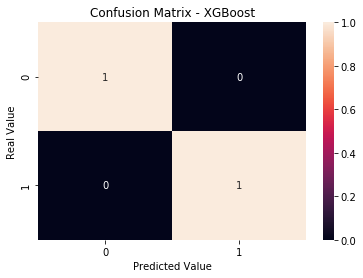

In [84]:
# final XGBoost model
xgb = XGBClassifier(max_depth=1, learning_rate=0.0001, n_estimators=50, gamma=0, min_child_weight=1)
xgb.fit(X_train, y_train)

# prediction
X_test_xgb = scaler.transform(X_test)
y_pred_xgb = xgb.predict(X_test_xgb)

# classification report
print(classification_report(y_test, y_pred_xgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - XGBoost')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.33      1.00      0.50         2

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6



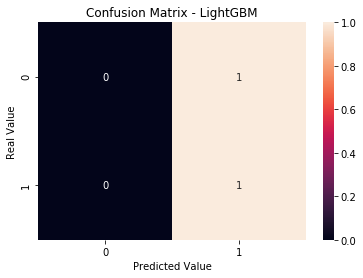

In [86]:
# final LightGBM model
lgb = LGBMClassifier(num_leaves=20, max_depth=5, learning_rate=0.001, min_data_in_leaf=100)
lgb.fit(X_train, y_train)

# prediction
X_test_lgb = scaler.transform(X_test)
y_pred_lgb = lgb.predict(X_test_lgb)

# classification report
print(classification_report(y_test, y_pred_lgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_lgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - LightGBM')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         4
         1.0       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



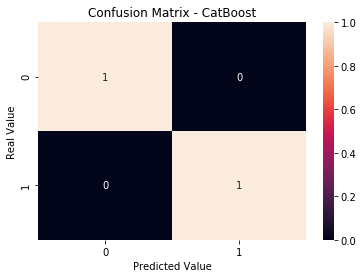

In [88]:
# final CatBoost model
cb = CatBoostClassifier(learning_rate=0.03, depth=6, l2_leaf_reg=1, logging_level='Silent')

cb.fit(X_train, y_train)

# prediction
X_test_cb = scaler.transform(X_test)
y_pred_cb = cb.predict(X_test_cb)

# classification report
print(classification_report(y_test, y_pred_cb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_cb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - CatBoost')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()